In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn
%matplotlib inline


## first generate the dataset necessary for this model

In [5]:
qb_df = pd.read_csv('./dataset/QB_stats_and_fantasy_pts.csv',index_col=0)
def_df = pd.read_csv('./def_stats_and_fantasy_pts.csv',index_col=0)
game_df = pd.read_csv('./dataset/all_game_data.csv',index_col=0)

In [6]:
def find_opp_team(game_eid, team_known):
    teams = game_df[game_df.game_eid==game_eid].filter(axis=1,regex='team')
    if teams['home_team'].iloc[0] == team_known:
        return teams['away_team'].iloc[0]
    else:
        return teams['home_team'].iloc[0]
def generate_temporal_qb_data_for_week(qb_player_id,week,season):
    qb_current_time_slice = qb_df[ (qb_df.player_id== qb_player_id) & (qb_df.week == week) & (qb_df.season==season)]
    if len(qb_current_time_slice) == 0:
        return pd.DataFrame()
    qb_intertemp_data = qb_current_time_slice.filter(axis=1,regex="^passing*|^fantasy*").copy()
    curr_game = qb_current_time_slice['game_eid'].iloc[0]
    curr_team = qb_current_time_slice['team'].iloc[0]
    opp_team = find_opp_team(curr_game,curr_team)
    opp_sums = def_df[(def_df.game_eid == curr_game) & (def_df.team == opp_team) ].filter(axis=1,items=["defense_int","defense_sk","defense_tkl"]).sum()
    
    for col in opp_sums.index:
        qb_intertemp_data[col] = opp_sums[col]
    return qb_intertemp_data
    ##player ids to test:
    # 00-0035251 	
    # 00-0035146
    # 00-0022924
def query_data_for_season(season):
    all_uq_qbs = qb_df[qb_df.season==season]['player_id'].unique()
    acc = pd.DataFrame()
    for week in range(1,18):
        for uid in all_uq_qbs:
            temp = generate_temporal_qb_data_for_week(uid,week,season)
            temp['week'] = week
            temp['player_id'] = uid
            acc = pd.concat([acc,temp])
    return acc

In [7]:
season_qb_data  = query_data_for_season(2009)

In [8]:

non_temp_train_dataset =  season_qb_data[season_qb_data['week'] != 17].copy()
non_temp_train_dataset.drop(['week'],axis=1,inplace=True)
non_temp_test_dataset  = season_qb_data[season_qb_data['week'] == 17].copy()
non_temp_test_dataset.drop(['week'],axis=1,inplace=True)


# First lets make a bayesian network for one week, with the intratemporal connections:
1. passing_cmp -> passing_ints
2. defense_int -> passing_ints
3. defense_sk  -> passing_ints


In [9]:
non_temporal_basic_df = non_temp_train_dataset[['passing_cmp','passing_ints','defense_int','defense_sk']].copy()
# Discretize the continuous
non_temporal_basic_df['passing_cmp'] = pd.qcut(non_temp_train_dataset['passing_cmp'], q=5,labels=['few pass completes','some pass completes','median pass completes','good pass completes','amazing pass completes'])
for col in non_temporal_basic_df.columns[1:]:
    non_temporal_basic_df[col] = non_temporal_basic_df[col].apply(int)


In [10]:

pd.read_csv('non_temporal_basic_df.csv')

passing_cmp  passing_ints  defense_int  defense_sk
0    amazing pass completes             2            0           3
1       good pass completes             1            1           1
2       good pass completes             0            0           2
3       good pass completes             1            1           4
4        few pass completes             0            1           4
..                      ...           ...          ...         ...
587     good pass completes             2            2           3
588   median pass completes             3            1           3
589  amazing pass completes             3            1           4
590   median pass completes             2            1           2
591      few pass completes             1            1           1

[592 rows x 4 columns]

In [11]:
bn=gum.BayesNet('InterceptionsInWeek')
print(bn)
bn_node_dict = {} #tuple list to save column name for sanity
for col in non_temporal_basic_df.columns:
    labels = [str(x) for x in sorted(non_temporal_basic_df[col].unique())]
    node = bn.add(gum.LabelizedVariable(col,col,labels))
    bn_node_dict[col] = node
print(bn)

BN{nodes: 0, arcs: 0, domainSize: 1, dim: 0}
BN{nodes: 4, arcs: 0, domainSize: 1440, dim: 25}


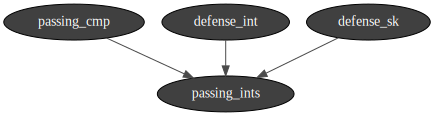

In [12]:
edges = [("passing_cmp", "passing_ints"),("defense_int","passing_ints"),( "defense_sk" , "passing_ints")]
for parent,child in edges:
    bn.addArc(bn_node_dict[parent],bn_node_dict[child])
bn.generateCPTs()
gnb.showBN(bn,size=200)


## With the structure defined, lets try to make it learn from our dataset. 
### First, lets learn from the parameters of our datset. Then, we could try to infer structure. 

as weird take, the BN learner learns from a file, which is kinda weird. So we export our learning csv as a temp.csv.

we also need to pass the reference to the DAG underlying the Bayes net to the learner too. 

In [13]:
non_temporal_basic_df.to_csv('non_temporal_basic_df.csv',index=False)
learner = gum.BNLearner('non_temporal_basic_df.csv',bn)

In [14]:
learner.useScoreAIC()
learned_bn=learner.learnParameters(bn.dag(),True)

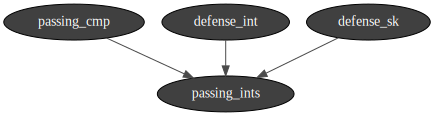

In [15]:
gnb.showBN(learned_bn,size=200)
#bn.dag()


## We can get the information graph 
This shows the entropy of the each of the related distributions

In [16]:
gnb.showInformation(bn,{},size="20")


## inference exploration
We can use the show inference function to obtain the marginal probability distribution for each random variable of a BayesNet

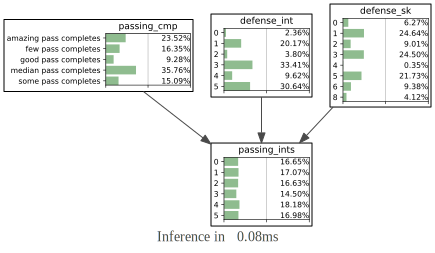

In [17]:
gnb.showInference(bn,size=200)

## We can now look at some of the marginal posteriors!

We can provide evidence with the "envs" dictionary. 


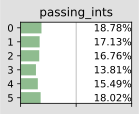

In [18]:
gnb.showPosterior(bn,evs={'defense_sk':"8"},target='passing_ints')

This makes sense, as defensive sacks have the highest relative entropy in this Bayesian Network, so they dont necessarily inform us of a whole lot. 

Lets try it with the other variables!

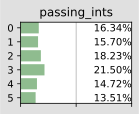

In [19]:
gnb.showPosterior(bn,evs={"defense_int":"0"},target='passing_ints')

Now lets see if we can predict how passing interceptions include the parent variables:

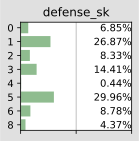

In [20]:
gnb.showPosterior(bn,evs={"passing_ints":"5"},target='defense_sk')

## Lets next make a DBN to start with a smaller DBN to see how this works. 
We are gonna try to model how passing interceptions happen through time, with the following vars:

passing_cmp, passing_ints, defense_int, defense_sk

intra temporal connections:

1. passing_cmp -> passing_ints
2. defense_int -> passing_ints
3. defense_sk  -> passing_ints

inter temporal connections:
1. passing_cmp -> passing_cmp
2. defense_int -> defense_int
3. defense_int -> defense_int




### Parsing Data
We are doing a lot of column manipulation because:
The naming convention for a 2TBN : a variable with a name A is present at t=0 with the name A0 and at time t as At.

In [21]:
tempo_train_dataset =  season_qb_data[season_qb_data['week'] != 17].copy()
tempo_test_dataset  = season_qb_data[season_qb_data['week'] == 17].copy()
temporal_basic_df = tempo_train_dataset[['passing_cmp','passing_ints','defense_int','defense_sk','week']].copy()
# Discretize the continuous
temporal_basic_df['passing_cmp'] = pd.qcut(temporal_basic_df['passing_cmp'], q=5,labels=['bad pass completes','some pass completes','median pass completes','good pass completes','amazing pass completes'])
for col in temporal_basic_df.columns[1:]:
    temporal_basic_df[col] = temporal_basic_df[col].apply(int)
#create inital columns (t = 0 ), and temporal columns (t  > 0)
tmp_df_0 = temporal_basic_df[temporal_basic_df['week']==1]
tmp_df_t = temporal_basic_df[temporal_basic_df['week']!=1]
#drop week (temporarily). we are only using it for initalization. 
tmp_df_0.drop(['week'],axis=1,inplace=True)
tmp_df_t.drop(['week'],axis=1,inplace=True)
#reindex
tmp_df_0.index=range(tmp_df_0.shape[0])
tmp_df_t.index=range(tmp_df_t.shape[0])
#follow convention
tmp_df_0.columns = [col+'0' for col in tmp_df_0.columns]
tmp_df_t.columns = [col+'t' for col in tmp_df_t.columns]

combined_df = pd.concat([tmp_df_0,tmp_df_t],axis=1)

/home/owleyes/anaconda3/envs/stat/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
first_two_dbn = gum.BayesNet()
feature_dict = {}
for col in tmp_df_0.columns:
    labels = [str(x) for x in sorted(set(tmp_df_0[col].values).union(tmp_df_t[col[:-1]+'t'].values))]
    node = first_two_dbn.add(gum.LabelizedVariable(col,col,labels))
    feature_dict[col] = node
for col in tmp_df_t.columns:
    labels = [str(x) for x in sorted(set(tmp_df_0[col[:-1]+'0'].values).union(tmp_df_t[col].values))]
    node = first_two_dbn.add(gum.LabelizedVariable(col,col,labels))
    feature_dict[col] = node

print(first_two_dbn)

BN{nodes: 8, arcs: 0, domainSize: 10^6.31672, dim: 50}


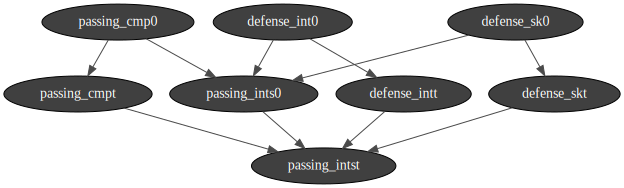

In [23]:
edges = [
    ("passing_cmp0", "passing_ints0"),("defense_int0","passing_ints0"),( "defense_sk0" , "passing_ints0"), #t=0 edges
    ("passing_cmpt", "passing_intst"),("defense_intt","passing_intst"),( "defense_skt" , "passing_intst"), #t=t edges
    ("passing_cmp0", "passing_cmpt"),("defense_int0","defense_intt"),( "defense_sk0" , "defense_skt"), ('passing_ints0','passing_intst') #inter-temporal edges
        ]
for parent,child in edges:
    first_two_dbn.addArc(feature_dict[parent],feature_dict[child])
first_two_dbn.generateCPTs()
gnb.showBN(first_two_dbn,size=200)


# This isn't a 2-tbn, but since we named our variables with convention, we can get a 2-tbn vizualization!

In [24]:
#gdyn.showTimeSlices(first_two_dbn)
sorted(set(tmp_df_0['defense_sk0'].values).union(tmp_df_t['defense_skt'].values))

[0, 1, 2, 3, 4, 5, 6, 8]

### We can unroll the 2-TBN for T time steps as follows:

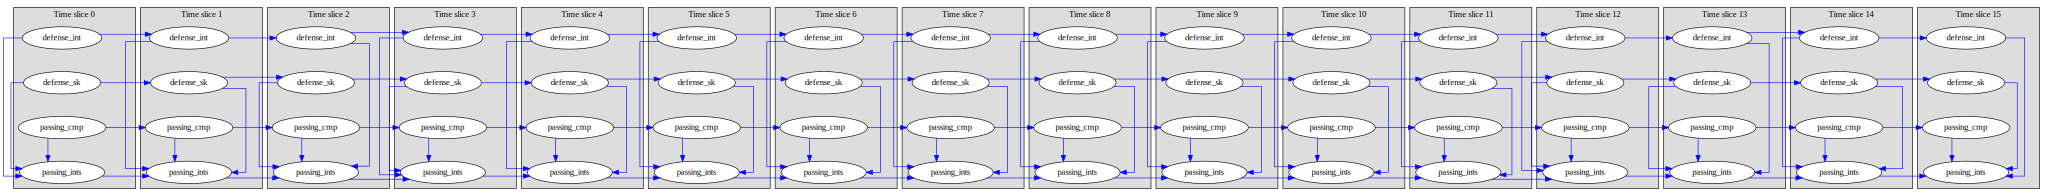

In [25]:
T=16

unroll_dbn=gdyn.unroll2TBN(first_two_dbn,T)
gdyn.showTimeSlices(unroll_dbn,size='100')

In [ ]:
gnb.showBN(unroll_dbn,size=100)


# Training the 2-tbn
## we do more data processing to get the data to fit the column names

In [26]:
temp_train_df =  season_qb_data[season_qb_data['week'] != 17].copy()
temp_train_df = temp_train_df[['passing_cmp','defense_sk','passing_ints','defense_int','week']]
temp_train_df['passing_cmp'] = pd.qcut(temp_train_df['passing_cmp'], q=5,labels=['bad pass completes','some pass completes','median pass completes','good pass completes','amazing pass completes'])
for col in temp_train_df.columns[1:]:
    temp_train_df[col] = temp_train_df[col].apply(int)
finalized_temporal_train_dfs = []
for wk in temp_train_df['week'].unique():
    wk_df = temp_train_df[temp_train_df['week'] == wk].copy()
    wk_df.columns = [col+str(wk-1) for col in wk_df.columns ]
    wk_df.index = range(wk_df.shape[0])
    finalized_temporal_train_dfs.append(wk_df)
final_temp_train = pd.concat(finalized_temporal_train_dfs)

for col in final_temp_train.columns:
    if 'passing_cmp' not in col:
        final_temp_train[col].fillna(value='',inplace=True)
        final_temp_train[col] = final_temp_train[col].apply(lambda x:  int(x) if x!= '' else 'nan') 
    else:
        final_temp_train[col] = final_temp_train[col].apply(str)

final_temp_train.head()

passing_cmp0 defense_sk0 passing_ints0 defense_int0 week0  \
0   amazing pass completes           3             2            0     1   
1      good pass completes           1             1            1     1   
2      good pass completes           2             0            0     1   
3      good pass completes           4             1            1     1   
4       bad pass completes           4             0            1     1   
..                     ...         ...           ...          ...   ...   
33                     nan         nan           nan          nan   nan   
34                     nan         nan           nan          nan   nan   
35                     nan         nan           nan          nan   nan   
36                     nan         nan           nan          nan   nan   
37                     nan         nan           nan          nan   nan   

   passing_cmp1 defense_sk1 passing_ints1 defense_int1 week1  ...  \
0           nan         nan           nan          nan   nan  ...   
1           nan         nan           nan          nan   nan  ...   
2           nan         nan           nan          nan   nan  ...   
3           nan         nan           nan          nan   nan  ...   
4           nan         nan           nan          nan   nan  ...   
..          ...         ...           ...          ...   ...  ...   
33          nan         nan           nan          nan   nan  ...   
34          nan         nan           nan          nan   nan  ...   
35          nan         nan           nan          nan   nan  ...   
36          nan         nan           nan          nan   nan  ...   
37          nan         nan           nan          nan   nan  ...   

   passing_cmp14 defense_sk14 passing_ints14 defense_int14 week14  \
0            nan          nan            nan           nan    nan   
1            nan          nan            nan           nan    nan   
2            nan          nan            nan           nan    nan   
3            nan          nan            nan           nan    nan   
4            nan          nan            nan           nan    nan   
..           ...          ...            ...           ...    ...   
33           nan          nan            nan           nan    nan   
34           nan          nan            nan           nan    nan   
35           nan          nan            nan           nan    nan   
36           nan          nan            nan           nan    nan   
37           nan          nan            nan           nan    nan   

             passing_cmp15 defense_sk15 passing_ints15 defense_int15 week15  
0                      nan          nan            nan           nan    nan  
1                      nan          nan            nan           nan    nan  
2                      nan          nan            nan           nan    nan  
3                      nan          nan            nan           nan    nan  
4                      nan          nan            nan           nan    nan  
..                     ...          ...            ...           ...    ...  
33     good pass completes            3              2             2     16  
34   median pass completes            3              3             1     16  
35  amazing pass completes            4              3             1     16  
36   median pass completes            2              2             1     16  
37      bad pass completes            1              1             1     16  

[592 rows x 80 columns]

# We are going to learn using the EM algorithm with Apriori Smoothing and without, and compare the results:

In [89]:
final_temp_train.to_csv('temporal_basic_df.csv',index=False)
dbn_learner = gum.BNLearner('temporal_basic_df.csv',unroll_dbn,['nan',''])
dbn_learner.setInitialDAG(unroll_dbn.dag())
dbn_learner.setVerbosity(True)
dbn_learner.useEM(1e-8)
trained_dbn = dbn_learner.learnParameters()

In [90]:
print(dbn_learner.history())
dbn_learner_smooth = gum.BNLearner('temporal_basic_df.csv',unroll_dbn,['nan',''])
dbn_learner_smooth.useAprioriSmoothing()
dbn_learner_smooth.setInitialDAG(unroll_dbn.dag())
dbn_learner_smooth.setVerbosity(True)
dbn_learner_smooth.useEM(1e-8)
trained_dbn_smooth = dbn_learner.learnParameters()

(3.3153496718115822, 0.7525646746584553, 0.7559666758515722)


In [94]:
gnb.sideBySide(gnb.getInference(trained_dbn_smooth,size=200),gnb.getInference(trained_dbn,size=200))
#gnb.getInference(trained_dbn_smooth,size=200)

## We can see how these distributions change across time:

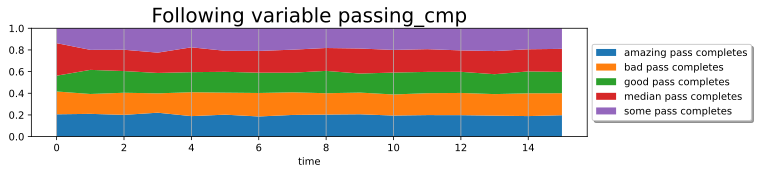

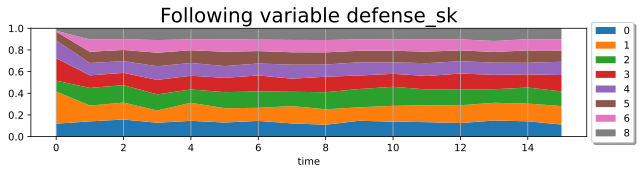

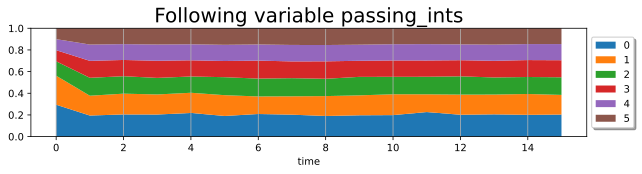

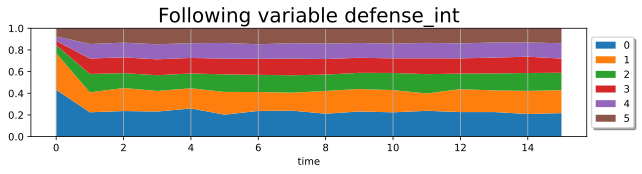

In [81]:
plt.rcParams['figure.figsize'] = (10, 2)
gdyn.plotFollowUnrolled(['passing_cmp','defense_sk','passing_ints','defense_int'],trained_dbn,T=16,evs={})  

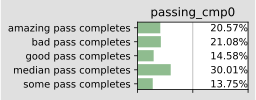

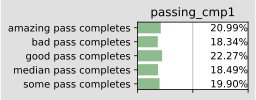

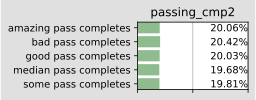

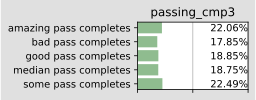

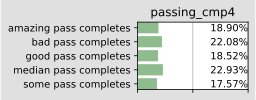

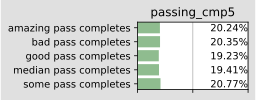

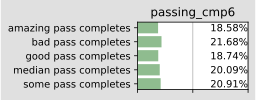

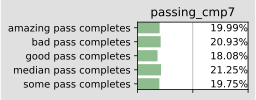

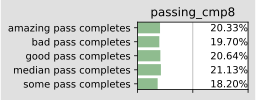

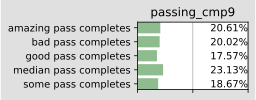

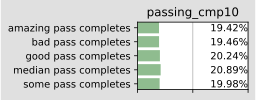

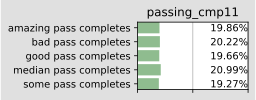

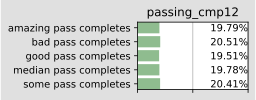

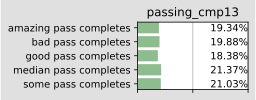

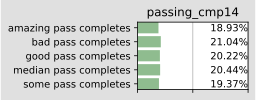

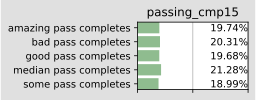

In [82]:
def show_posterior_through_time(tdbn,var,evs={}):
    for i in range(T):
        gnb.showPosterior(tdbn,target=var+"{}".format(i),evs=evs)
show_posterior_through_time(trained_dbn,'passing_cmp',{})

## Lets run gibbs sampling on this DBN

Lets also compare how they work on different hyper parameters

In [83]:
def compareInference(ie,ie2,ax=None):
    """
    compare 2 inference by plotting all the points from (posterior(ie),posterior(ie2))
    """
    exact=[]
    appro=[]
    errmax=0
    for node in bn.nodes():
        # potentials as list
        exact+=ie.posterior(node).tolist()
        appro+=ie2.posterior(node).tolist()
        errmax=max(errmax,
                   (ie.posterior(node)-ie2.posterior(node)).abs().max())
    
    if errmax<1e-10: errmax=0
    if ax==None:
        ax=plt.gca() # default axis for plt
           
    ax.plot(exact,appro,'ro')
    ax.set_title("{} vs {}\n {}\nMax error {:2.4} in {:2.4} seconds".format(
        str(type(ie)).split(".")[2].split("_")[0][0:-2], # name of first inference
        str(type(ie2)).split(".")[2].split("_")[0][0:-2], # name of second inference
        ie2.messageApproximationScheme(),
        errmax,
        ie2.currentTime())
                )


In [84]:

gibbs_sampler = gum.GibbsSampling(trained_dbn)
gibbs_sampler.setMaxTime(100)
gibbs_sampler.setEpsilon(1e-2)
gibbs_sampler.makeInference()


exact=gum.LazyPropagation(trained_dbn)
exact.makeInference()



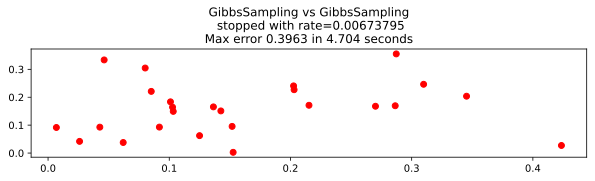

In [95]:
compareInference(gibbs_sampler,ie2)

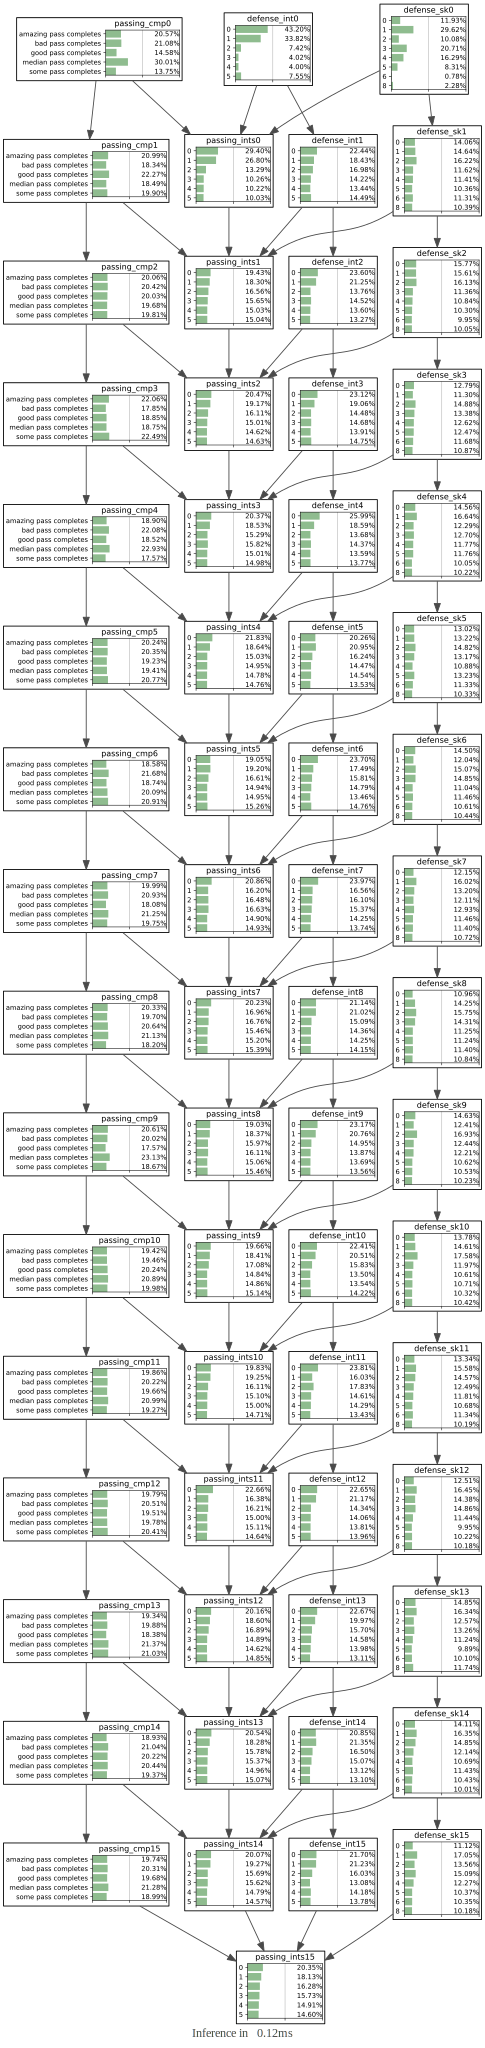

In [86]:
gnb.showInference(trained_dbn,engine=exact,size='100')